The dataset contains pathology images for classification. Each image is labeled with an image ID, and the ground truth labels for the training images are provided in a file named "train_labels.csv." . A positive label indicates that the central 32x32 pixels region of a patch contains at least one pixel of tumor tissue, while tumor tissue in the outer region of the patch does not influence the label. The dataset does not contain duplicate images, unlike the original PCam dataset, and maintains the same data and splits as the PCam benchmark. This dataset enables the development of fully-convolutional models for pathology image classification.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 colu

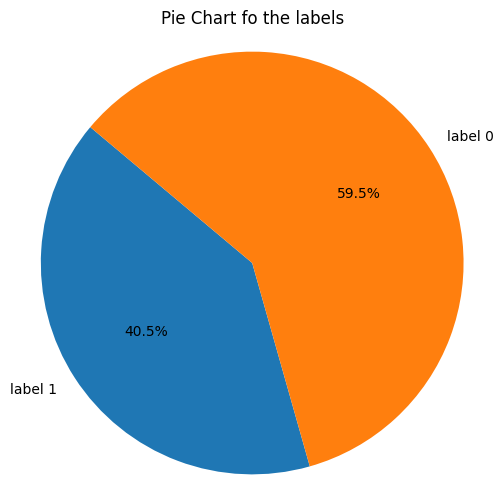

In [13]:
import pandas as pd
import random
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import os
from keras.models import load_model 
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt54q
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from tensorflow.keras.layers import Activation, Flatten, Dropout

data = pd.read_csv('train_labels.csv')
ruta_imagenes = "C:\\Users\\arria\\Documents\\Maestría\\Especializacion_IA\\Convolution_network\\train_images\\"
print(data.head())
print(data)
print(data.info())
K.set_image_data_format('channels_last')
sizes = [(data['label'] == 1).sum(),(data['label'] == 0).sum()] 
etiquetas = ['label 1', 'label 0']  
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=etiquetas, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Pie Chart fo the labels')
plt.show()

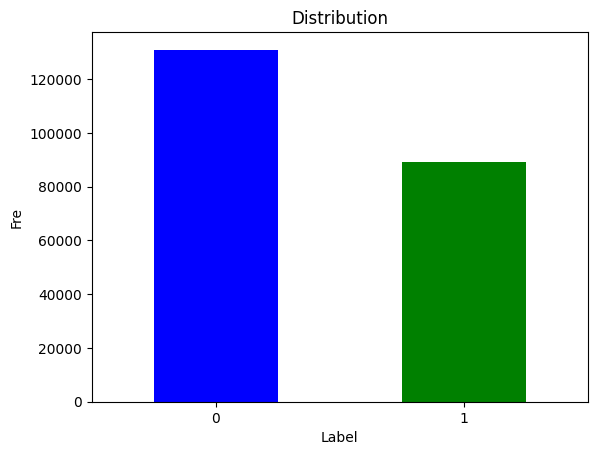

In [14]:
frecuencia = data['label'].value_counts()
frecuencia.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution')
plt.xlabel("Label")
plt.ylabel('Fre')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.show()

In [15]:
data = data.drop_duplicates(subset=['id'])
data = data.dropna()
print(data.head())
print(data)
print(data.info())
sizes = [(data['label'] == 1).sum(),(data['label'] == 0).sum()]  

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 colu

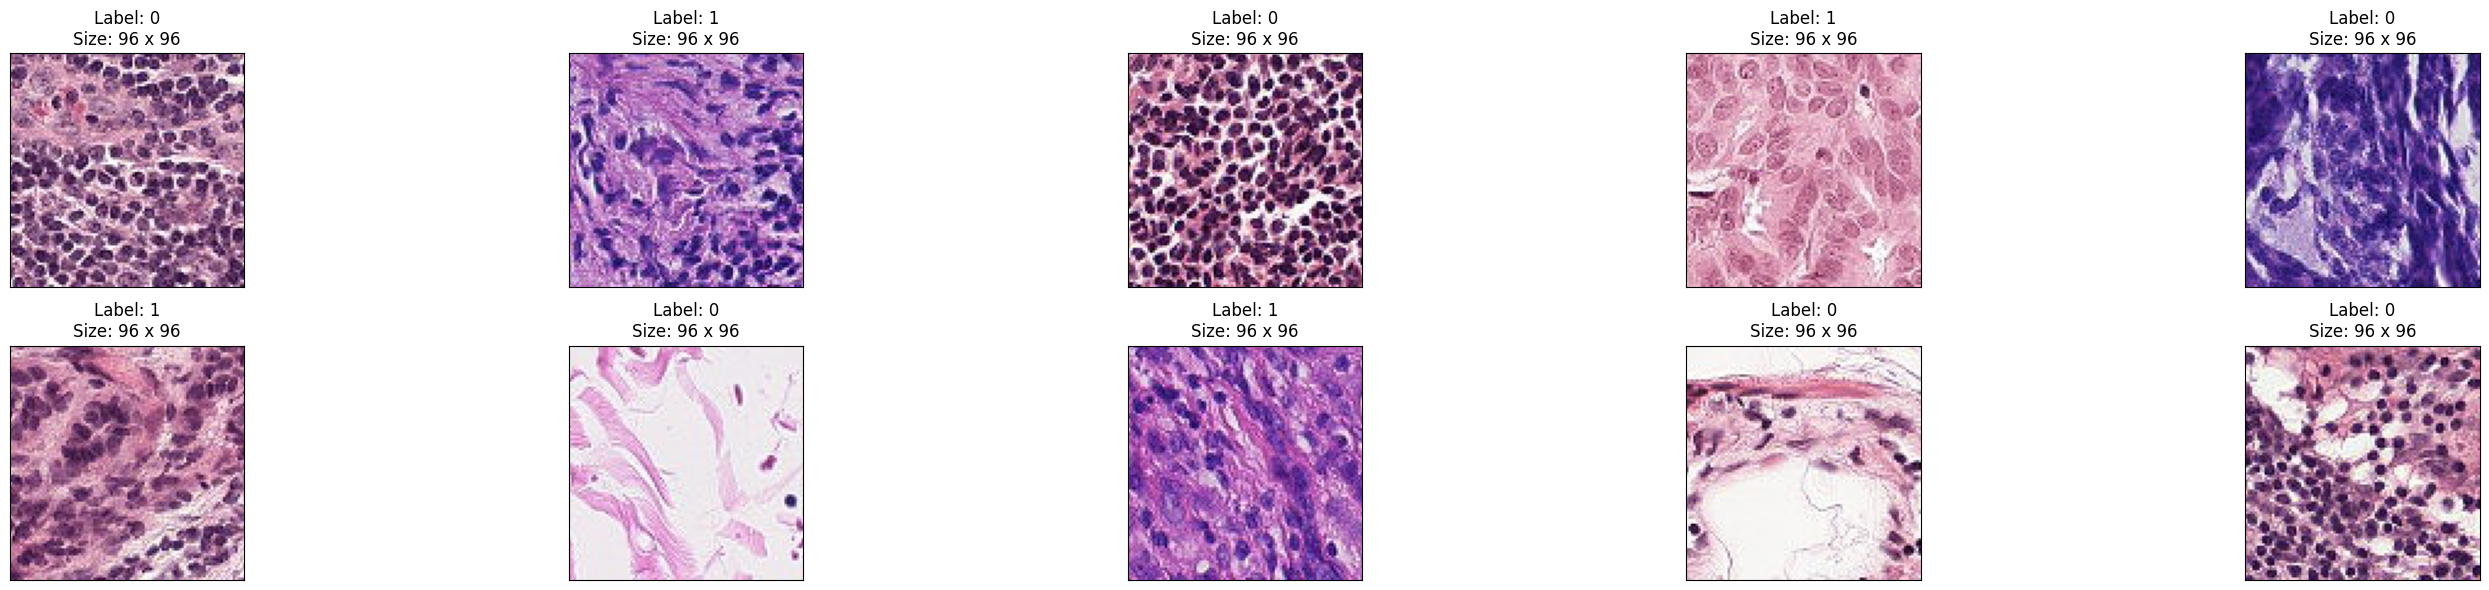

In [16]:
fig = plt.figure(figsize=(30, 6))

for i in range(10):
    indice_aleatorio = random.randint(0, len(data.index) - 1)
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    nombre_imagen = data['id'].iloc[indice_aleatorio] + ".tif"
    imagen = Image.open(ruta_imagenes + nombre_imagen)
    ancho, alto = imagen.size
    ax.set_title('Label: %s\nSize: %d x %d' % (data['label'].iloc[indice_aleatorio], ancho, alto))
    plt.imshow(imagen)
plt.tight_layout()
plt.show()

I will use six layers: four convolutional layers, one Flatten layer, and the output layer. The first two layers will be responsible for identifying elements in the images an the other two will abstract the big features. Since they have low resolution (96 x 96 pixels), a kernel of one pixel will be used for small elements, 3 x 3 for medium-sized elements and for the big features will be a one layer of one pixel and another of 3x3 pixels . Both layers will have a stride of 2 to reduce processing time and 'same' padding to avoid losing information from the edges. The Flatten layer is used to convert the result into a vector to input it into the last layer and obtain a single output value. The last layer is a perceptron with a sigmoid activation function, since the result is binary. Finally, an optimizer 'adam' and a loss function called binary_crossentropy will be implemented.

In [22]:
config_layers = [
    Conv2D(filters=256, kernel_size=(1, 1),strides=2,padding="same", input_shape=(96, 96, 3)),
    Conv2D(filters=256, strides=2,kernel_size=(3, 3),padding="same"),
    Conv2D(filters=128, strides=2,kernel_size=(1, 1),padding="same"),
    Conv2D(filters=128, strides=2,kernel_size=(3, 3),padding="same"),
    Flatten(),
    Dense(units=1, activation="sigmoid")
]
model=Sequential(config_layers)
sgd_optimizer = SGD(learning_rate=0.0001, momentum=60.001)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 776,193 (2.96 MB)

 Trainable params: 776,193 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.5863 - loss: 5.3792 - val_accuracy: 0.3650 - val_loss: 852.0569
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.3850 - loss: 816.0522 - val_accuracy: 0.6350 - val_loss: 168.2671
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.6150 - loss: 174.9283 - val_accuracy: 0.6350 - val_loss: 83.8304
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.6150 - loss: 87.3919 - val_accuracy: 0.3650 - val_loss: 281.5371
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.3850 - loss: 269.2448 - val_accuracy: 0.3650 - val_loss: 153.9206
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3850 - loss: 146.8367 - val_accuracy: 0.6350 - val_loss: 48.1491
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6150 - loss: 49.5135 - val_accuracy: 0.6350 - val_loss: 70.8749
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6150 - loss: 72.8719 - val_accura

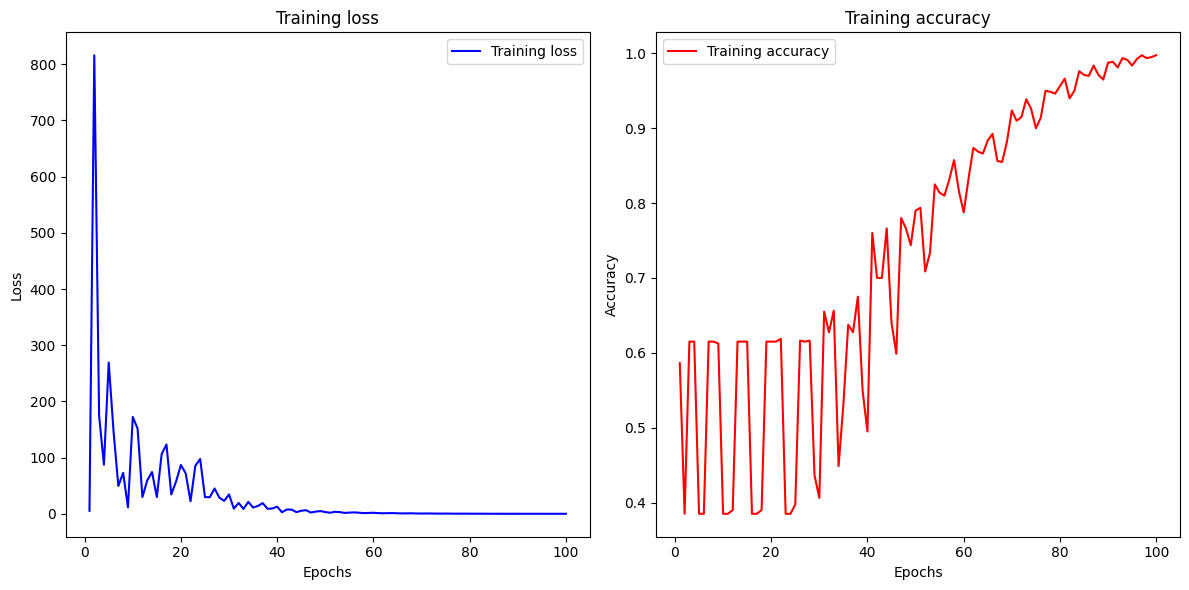

In [23]:
# Shuffle the DataFrame and reset index
data_s = data.sample(frac=1).reset_index(drop=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_s['id'], data_s['label'], test_size=0.3, random_state=42)

# Define the path to the directory containing the training images
ruta_imagenes = "C:\\Users\\arria\\Documents\\Maestría\\Especializacion_IA\\Convolution_network\\train_images\\"

# Define the batch size
batch = 1000

# Initialize lists to store input images and labels
input_images = []
input_y = []

# Loop over each batch
for i in range(0, batch):
    # Get the filename and label for the image
    nombre_imagen = X_train.iloc[i+batch] + ".tif"
    y = y_train.iloc[i]
    
    # Open the image using PIL and convert it to a NumPy array
    imagen = Image.open(ruta_imagenes + nombre_imagen)
    input_image = np.array(imagen)
    
    # Append the image and label to the lists
    input_images.append(input_image)
    input_y.append(y)

# Convert the lists to NumPy arrays
input_images = np.array(input_images)
input_y = np.array(input_y)

# Fit the model with the input images and labels, and validate with a validation split
history = model.fit(input_images, input_y, epochs=100, batch_size=batch, validation_split=0.2)

# Get the training metrics from the history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Create plots for training loss and accuracy over epochs
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [24]:
model.save("Convol_model_Cancer_99.87.h5")

In [25]:
# Load the trained model from the saved file
testmodel = load_model("Convol_model_Cancer_99.87.h5")

# Define the batch size for testing
batch_test = 1000

# Initialize lists to store input images, predicted labels, and true labels
input_images = []
predictions = []
y_true = []

# Initialize variables to keep track of already seen indices and images to show
i_past = []
show_images = 0  # Set to 1 to display images, 0 to skip

# Create a figure to display images (if enabled)
fig = plt.figure(figsize=(15, 20))

# Iterate over the test data
for j in range(batch_test):
    # Generate a random index for selecting a test sample
    i = random.randint(0, len(X_test.index) - 1) 
    
    # Ensure that the index hasn't been used before
    while i in i_past:
        i = random.randint(0, len(X_test.index) - 1) 
    
    # Add the current index to the list of seen indices
    i_past.append(i)
    
    # Get the filename and true label for the current test sample
    nombre_imagen = X_test.iloc[i] + ".tif"   
    y = y_test.iloc[i]
    
    # Open the image using PIL and convert it to a NumPy array
    imagen = Image.open(ruta_imagenes + nombre_imagen)
    input_image = np.array(imagen)
    
    # Expand dimensions to create a batch-like structure (required by the model)
    input_image = np.expand_dims(input_image, axis=0)
    
    # Get the model's prediction for the current test sample
    prediction = testmodel.predict(input_image)
    
    # Convert prediction to binary label (0 or 1)
    if prediction < 0.5:
        prediction = 0
    else:
        prediction = 1
    
    # If enabled, display the image with predicted and true labels
    if show_images == 1:
        ax = fig.add_subplot(4, 5, j+1, xticks=[], yticks=[])
        ancho, alto = imagen.size
        ax.set_title('Label predicted: %s\nLabel real: %s\nSize: %d x %d' % (prediction, y, ancho, alto))
        plt.imshow(imagen)
    
    # Append the prediction and true label to the respective lists
    predictions.append(prediction)
    y_true.append(y)

# Calculate the accuracy of the model by comparing predicted and true labels
accuracy = np.mean(np.array(predictions) == np.array(y_true))
print("Accuracy of the model:", accuracy)

# Adjust layout and display the images (if enabled)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━

<Figure size 1500x2000 with 0 Axes>

In [26]:
data = pd.read_csv('sample_submission.csv')
ruta_submission_imagenes = "C:\\Users\\arria\\Documents\\Maestría\\Especializacion_IA\\Convolution_network\\images\\"
print(data.head())
print(data)
print(data.info())
size=data.shape
print(size[0])

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
                                             id  label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1      95596b92e5066c5c52466c90b69ff089b39f2737      0
2      248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3      2c35657e312966e9294eac6841726ff3a748febf      0
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
...                                         ...    ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7      0
57454  6f3977130212641fd5808210015a609c658dcbff      0
57455  46935f247278539eca74b54d07d666efb528a753      0
57456  a09bcae08a82120183352e0e869181b2911d3dc1      0
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b      0

[57458 rows x 2 columns]
<class '

In [ ]:
# Initialize lists and variables to store input images, predicted labels, and true labels
input_images = []
predictions = []
y_true = []
i_past = []
show_images = 0  # Set to 1 to display images, 0 to skip

# Create a figure to display images (if enabled)
fig = plt.figure(figsize=(15, 20))

# Iterate over the test data
for j in range(0, size[0]):
    # Get the filename for the current test sample
    nombre_imagen = data["id"].iloc[j] + ".tif"
    print(j)
    # Open the image using PIL and convert it to a NumPy array
    imagen = Image.open(ruta_submission_imagenes + nombre_imagen)
    input_image = np.array(imagen)
    
    # Expand dimensions to create a batch-like structure (required by the model)
    input_image = np.expand_dims(input_image, axis=0)
    
    # Get the model's prediction for the current test sample
    prediction = model.predict(input_image)
    
    # Convert prediction to binary label (0 or 1)
    if prediction < 0.5:
        prediction = 0
    else:
        prediction = 1
    
    # Update the label in the DataFrame with the predicted value
    data.loc[j, "label"] = prediction

# The DataFrame 'data' now contains the predicted labels

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━

In [28]:
data.to_csv('Submission_1', index=False)